# Notebook link: https://colab.research.google.com/drive/1NsHD9110RdJxuOxwSKXJltCxu4qXYCVQ?usp=sharing

In [2]:
!pip install -q transformers timm inflect phonemizer datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 17.7 MB/s eta 0:00

In [3]:
!sudo apt-get install espeak

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-data libespeak1 libportaudio2 libsonic0
The following NEW packages will be installed:
  espeak espeak-data libespeak1 libportaudio2 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,382 kB of archives.
After this operation, 3,178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak-data amd64 1.48.15+dfsg-3 [1,085 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libespeak1 amd64 1.48.15+dfsg-3 [156 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak amd64 1.48.15+dfsg-3 [64.2 kB]
Fetched 1,382 kB in 1s (1,890 

In [4]:
from datasets import load_dataset
import torch
import soundfile as sf
from IPython.display import Audio as IPythonAudio
import os
from PIL import Image
import io
from transformers import pipeline
import inflect
import matplotlib.pyplot as plt

# helper functions

In [5]:
def render_results_in_image(in_pil_image, in_results):

  plt.figure(figsize=(16,10))
  plt.imshow(in_pil_image)
  ax = plt.gca()

  for prediction in in_results:

    x, y = prediction['box']['xmin'], prediction['box']['ymin']
    w = prediction['box']['xmax'] - x
    h = prediction['box']['ymax'] - y

    ax.add_patch(plt.Rectangle((x, y), w, h, fill= False, color = 'green', linewidth=2))

    ax.text(x, y, f"{prediction['label']}: {round(prediction['score']*100, 1)}", color = 'red')

  plt.axis('off')
  image_buf = io.BytesIO()
  plt.savefig(image_buf, format='png', bbox_inches= 'tight', pad_inches = 0)
  image_buf.seek(0)
  modified_img = Image.open(image_buf)
  plt.close
  return modified_img

In [6]:
def summarize_predictions_NL(predictions):
  summary = {}
  p = inflect.engine()

  for prediction in predictions:
    label = prediction['label']
    if label in summary:
      summary[label] += 1
    else:
      summary[label] = 1

    result_string = "In the image, there are: "

    for i, (label, count) in enumerate(summary.items()):
      count_string = p.number_to_words(count)
      result_string += f"{count_string} {label}"
      if count > 1:
        result_string += "s"

      result_string += " "

      if i == len(summary) - 2:
        result_string += "and "

    result_string = result_string.rstrip(', ') + '.'

  return result_string

In [7]:
def get_pipeline_prediction(pil_image):

  pipe_output = OD_pipe(pil_image)
  processed_image = render_results_in_image(raw_image, pipe_output)

  return pipe_output, processed_image

## Object Detection

In [8]:
OD_pipe = pipeline("object-detection", model="facebook/detr-resnet-50")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


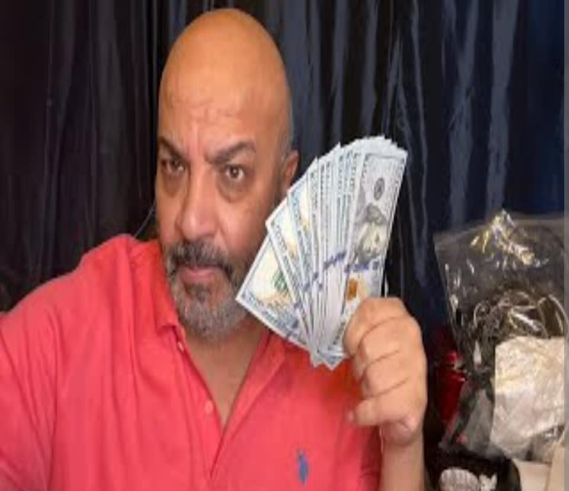

In [11]:
raw_image = Image.open('image.jpg')
raw_image.resize((569, 491))

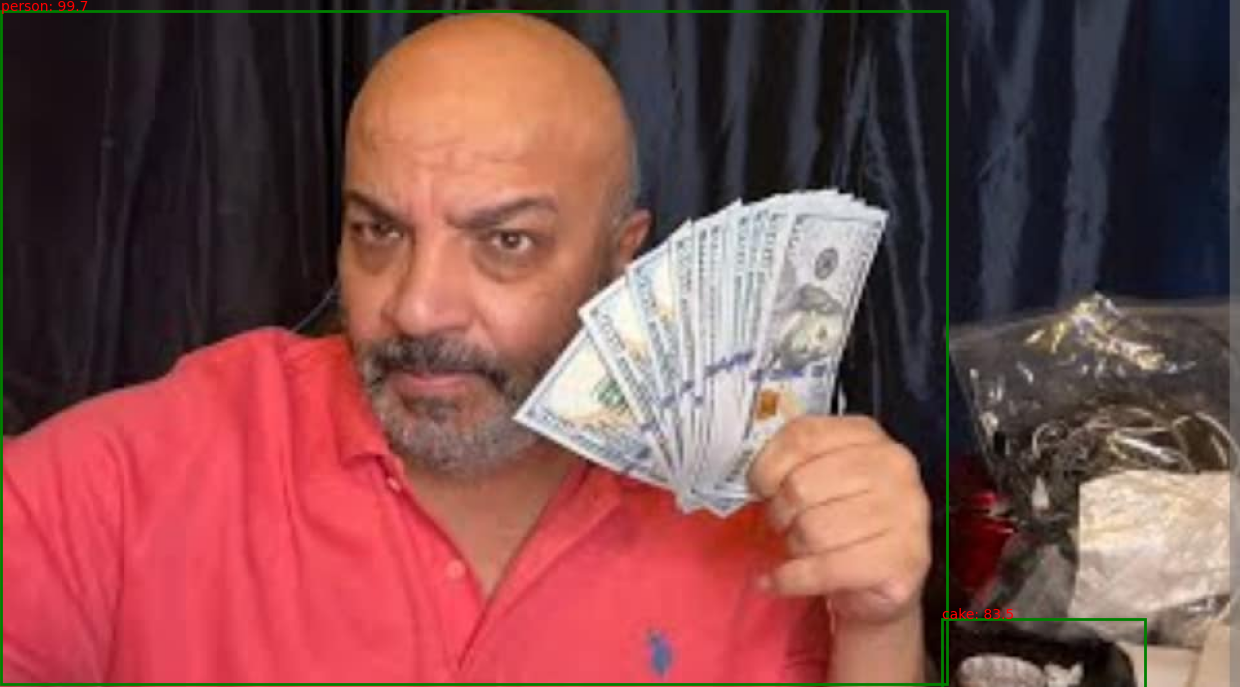

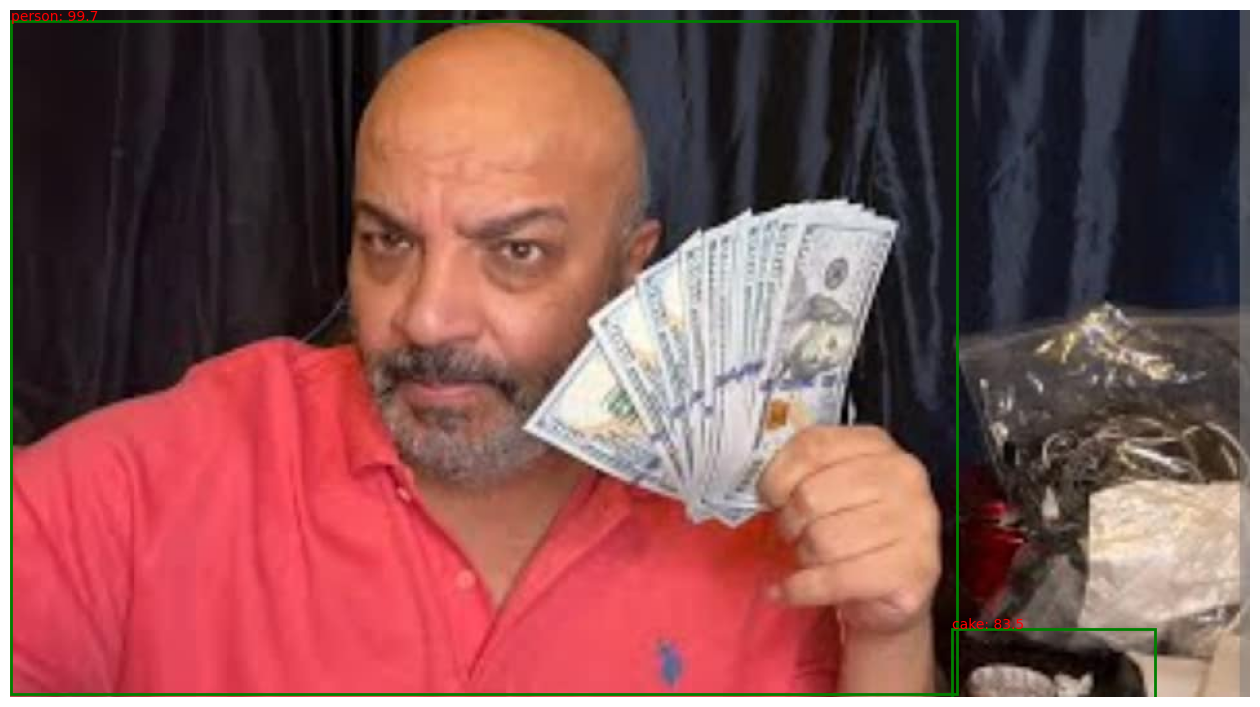

In [12]:
pipe_output, processed_image = get_pipeline_prediction(raw_image)
processed_image

In [13]:
text = summarize_predictions_NL(pipe_output)
text

'In the image, there are: one cake and one person.'

## English TTS

In [14]:
ttsEn_pipe = pipeline("text-to-speech", model="kakao-enterprise/vits-ljs")
narrated_text = ttsEn_pipe(text)

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [15]:
IPythonAudio(narrated_text['audio'][0], rate = narrated_text['sampling_rate'])

## Tranlation

In [16]:
trans_pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-ar")

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/917k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [17]:
translated_text = trans_pipe(text)
translated_text = translated_text[0]['translation_text']
translated_text

'في الصورة، هناك: كعكة واحدة وشخص واحد.'

## Arabic TTS

In [18]:
ttsAr_pipe = pipe = pipeline("text-to-speech", model="MBZUAI/speecht5_tts_clartts_ar")

config.json:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/403k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/458 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

In [19]:
embeddings_dataset = load_dataset("herwoww/arabic_xvector_embeddings", split="validation")

README.md:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/979k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/305 [00:00<?, ? examples/s]

In [20]:
speaker_embedding = torch.tensor(embeddings_dataset[0]["speaker_embeddings"]).unsqueeze(0)
speech = ttsAr_pipe(translated_text, forward_params={'speaker_embeddings': speaker_embedding})

model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

In [21]:
sf.write('speech.wav', speech['audio'], samplerate=speech["sampling_rate"])

In [22]:
IPythonAudio('speech.wav')

## Full Example

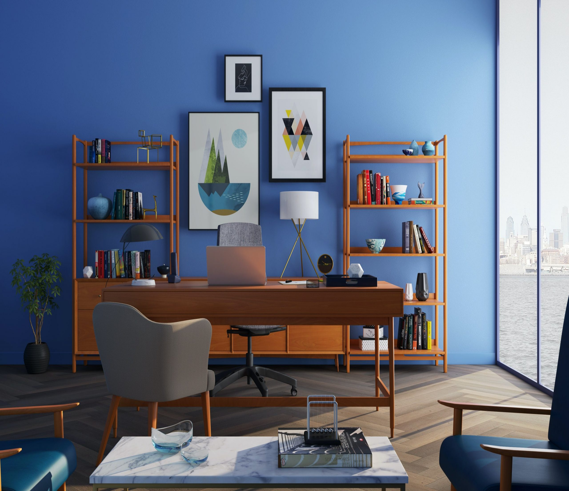

In [33]:
raw_image = Image.open('objects.png')
raw_image.resize((569, 491))

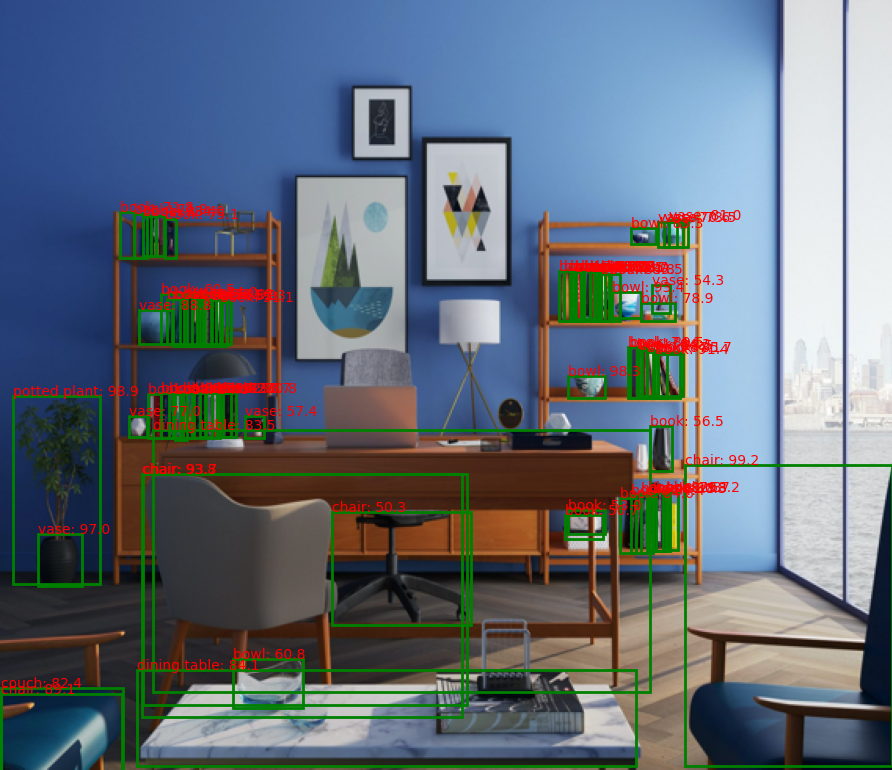

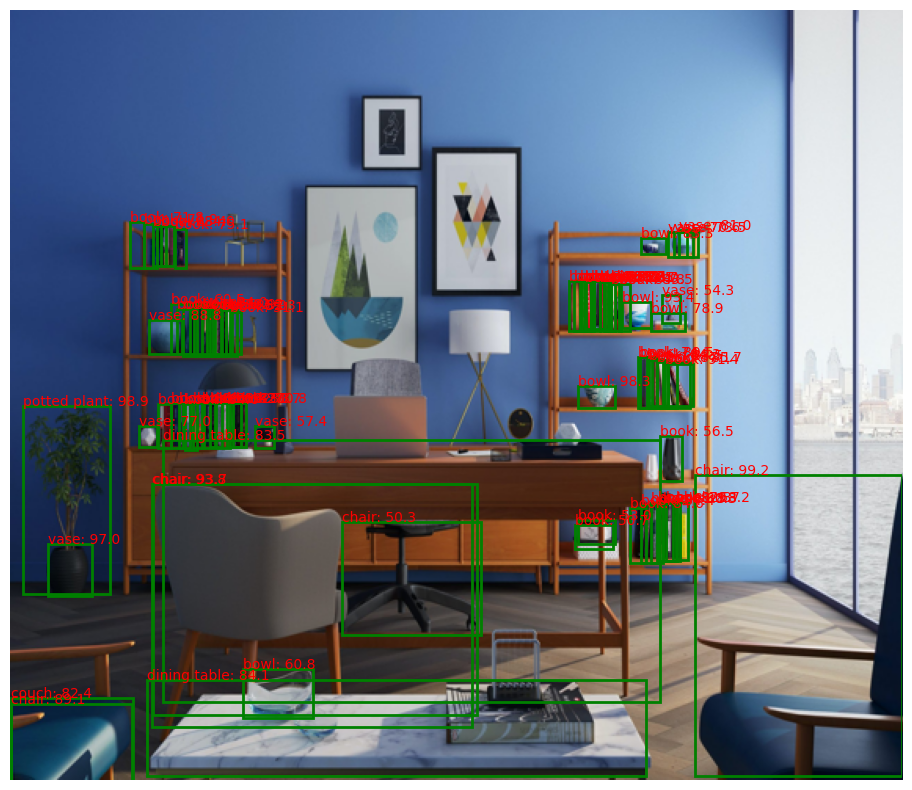

In [34]:
pipe_output, processed_image = get_pipeline_prediction(raw_image)
processed_image

In [36]:
pipe_output

[{'score': 0.9702602028846741,
  'label': 'vase',
  'box': {'xmin': 24, 'ymin': 340, 'xmax': 52, 'ymax': 373}},
 {'score': 0.8652546405792236,
  'label': 'book',
  'box': {'xmin': 363, 'ymin': 172, 'xmax': 370, 'ymax': 204}},
 {'score': 0.8252964019775391,
  'label': 'book',
  'box': {'xmin': 376, 'ymin': 173, 'xmax': 382, 'ymax': 203}},
 {'score': 0.5029468536376953,
  'label': 'chair',
  'box': {'xmin': 211, 'ymin': 326, 'xmax': 300, 'ymax': 398}},
 {'score': 0.8424022793769836,
  'label': 'book',
  'box': {'xmin': 122, 'ymin': 250, 'xmax': 130, 'ymax': 279}},
 {'score': 0.7506690621376038,
  'label': 'book',
  'box': {'xmin': 105, 'ymin': 139, 'xmax': 112, 'ymax': 164}},
 {'score': 0.839655339717865,
  'label': 'book',
  'box': {'xmin': 96, 'ymin': 137, 'xmax': 104, 'ymax': 163}},
 {'score': 0.8440364599227905,
  'label': 'book',
  'box': {'xmin': 402, 'ymin': 315, 'xmax': 412, 'ymax': 352}},
 {'score': 0.769919753074646,
  'label': 'vase',
  'box': {'xmin': 82, 'ymin': 265, 'xmax':

In [35]:
text = summarize_predictions_NL(pipe_output)
text

'In the image, there are: eight vases fifty-four books five chairs one couch one potted plant five bowls and two dining tables.'

In [37]:
narrated_text = ttsEn_pipe(text)

In [38]:
IPythonAudio(narrated_text['audio'][0], rate = narrated_text['sampling_rate'])

In [39]:
translated_text = trans_pipe(text)
translated_text = translated_text[0]['translation_text']
translated_text

'وفي الصورة، هناك: ثمانية زهريات أربعة وخمسون كتاباً خمسة مقاعد، وكرسي واحد أريكة واحدة، وأريكة واحدة، ونبتة واحدة، وخمسة أطباق، وطاولات طعام.'

In [40]:
speech = ttsAr_pipe(translated_text, forward_params={'speaker_embeddings': speaker_embedding})
sf.write('speech2.wav', speech['audio'], samplerate=speech["sampling_rate"])

In [41]:
IPythonAudio('speech2.wav')